### Demo for simple RAG using knowledge graphs and OCI Generative AI Service

In [2]:
# Import necessary functions and libraries
from show_graph import show_graph
from search_graph import search_graph
import oci

In [4]:
# Setup basic variables
# Auth Config
compartment_id = "[INSERT COMPARTMENT ID]"
CONFIG_PROFILE = "DEFAULT"
config = oci.config.from_file('~/.oci/config', CONFIG_PROFILE)

# Service endpoint, Frankfurt or Chicago
endpoint = "https://inference.generativeai.eu-frankfurt-1.oci.oraclecloud.com"

In [ ]:
# User query
query = "Who is Warren Buffets father?"
# Get most relevant relations
# TODO add parameters for choosing best n relations. Currently set to 5.
relations = search_graph(query, False, False)

Example output:
- ('Warren Edward Buffett', 'is', 'businessman')
- ('Warren Edward Buffett', 'is son of', 'Howard Buffett')
- ('Warren Edward Buffett', 'is', 'philanthropist')
- ('Warren Edward Buffett', 'is', 'investor')
- ('Warren Edward Buffett', 'pursued', 'business career')

In [ ]:
# Show a partial knowledge graph
head, relation, tail = list(zip(*relations))
show_graph(head, relation, tail)

Example output:
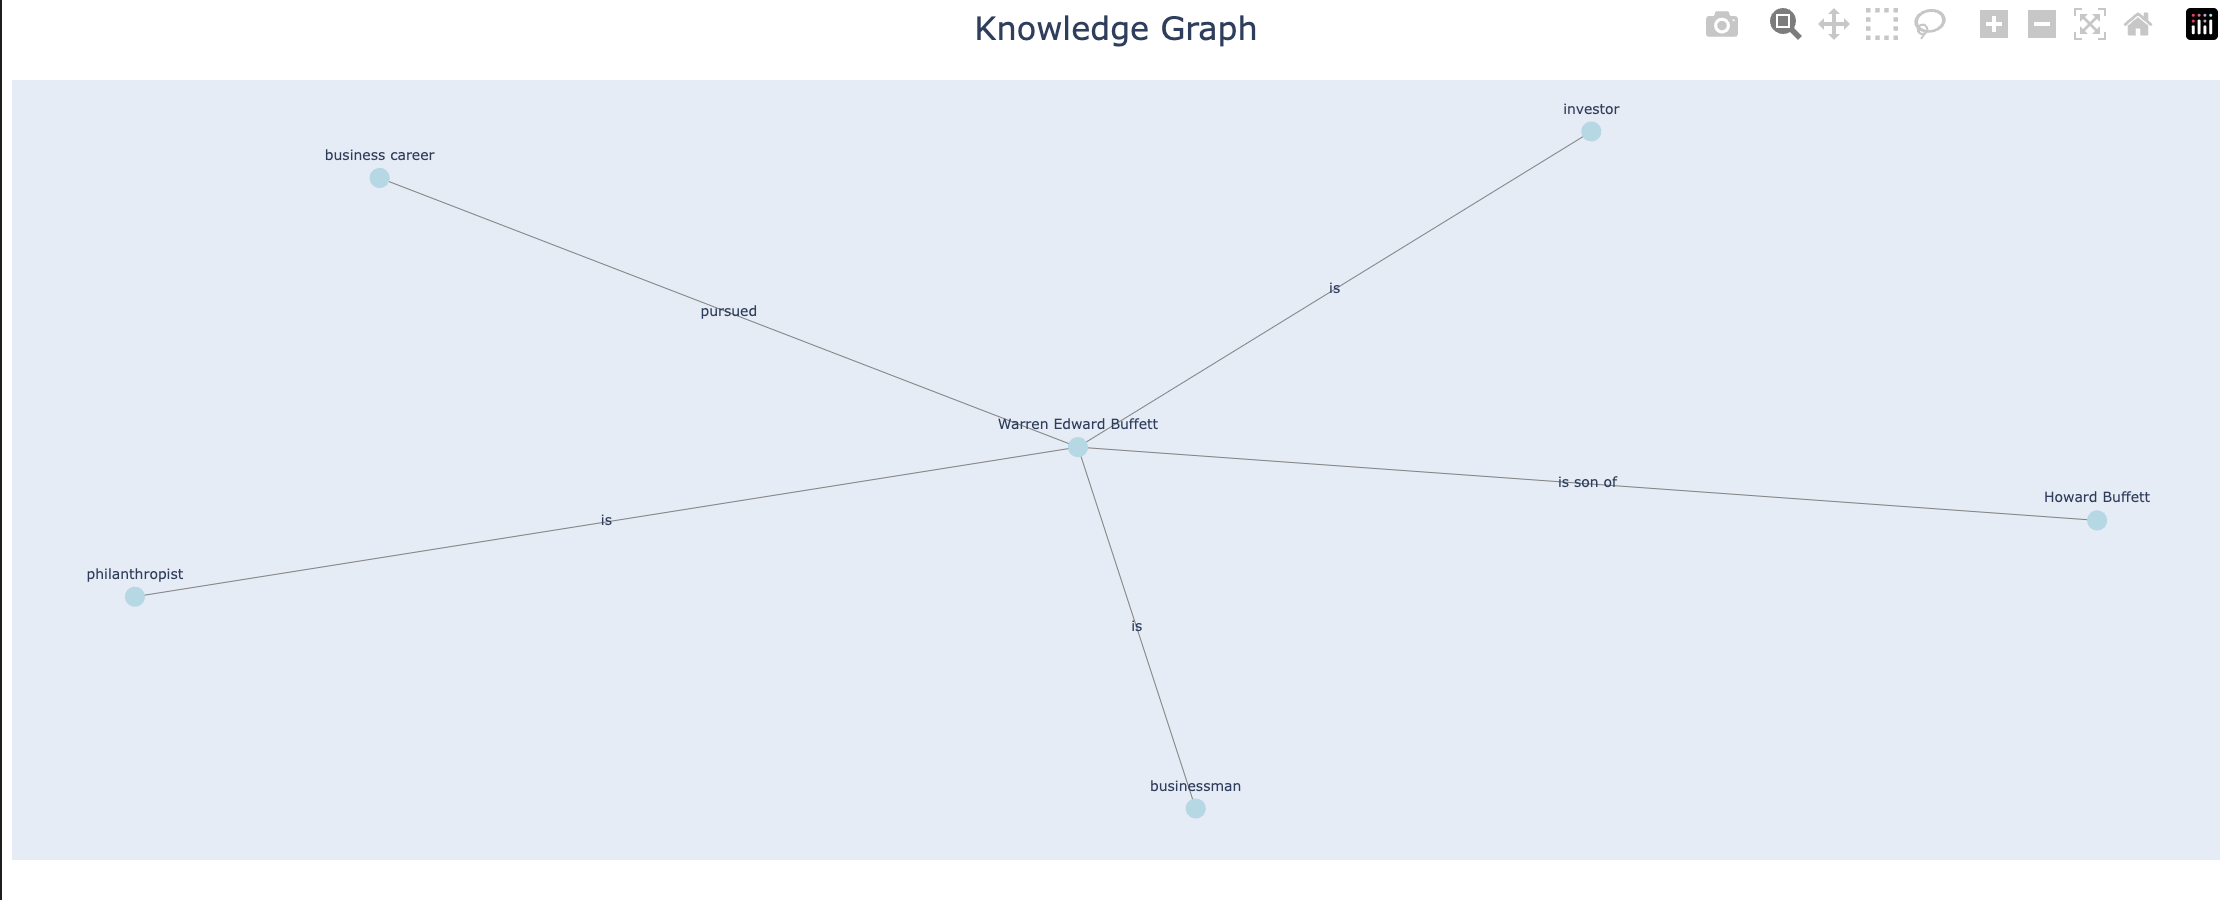

In [9]:
# Define rerank query
rerank_query = f'''Rerank the following knowledge graph relations based on their relevance to the query. 
            Output only the same relations in the reranked order without any further explanation: 
            QUERY: {query}
            RELATIONS: {relations}'''

In [ ]:
# Perform reranking
generative_ai_inference_client = oci.generative_ai_inference.GenerativeAiInferenceClient(config=config, service_endpoint=endpoint, retry_strategy=oci.retry.NoneRetryStrategy(), timeout=(10,240))
rerank_chat_detail = oci.generative_ai_inference.models.ChatDetails()

rerank_chat_request = oci.generative_ai_inference.models.CohereChatRequest()
rerank_chat_request.message = rerank_query
rerank_chat_request.max_tokens = 800
rerank_chat_request.temperature = 0.2
rerank_chat_request.frequency_penalty = 0
rerank_chat_request.top_p = 0.75
rerank_chat_request.top_k = 0


rerank_chat_detail.serving_mode = oci.generative_ai_inference.models.OnDemandServingMode(model_id="ocid1.generativeaimodel.oc1.eu-frankfurt-1.amaaaaaask7dceyazi3cpmptwa52f7dgwyskloughcxtjgrqre3pngwtig4q")
rerank_chat_detail.chat_request = rerank_chat_request
rerank_chat_detail.compartment_id = compartment_id
rerank_chat_response = generative_ai_inference_client.chat(rerank_chat_detail)
# Print result
print("**************************Chat Result**************************")
# Reranked relations
reranked_relations = vars(rerank_chat_response)["data"].chat_response.chat_history[1].message
print(reranked_relations)

In [ ]:
# Get best n after reranking, currently set to 3
# TODO make this a bit smarter 
context_relations = "".join(list(filter(lambda x: len(x) > 1, [i + ']' for i in reranked_relations.split("]")]))[:3])

Example output:
- ['Warren Edward Buffett', 'is son of', 'Howard Buffett']
- ['Warren Edward Buffett', 'is', 'businessman']
- ['Warren Edward Buffett', 'is', 'investor']

In [48]:
# Define RAG query
rag_query = f'''You are an assistant for question-answering tasks. Use the following pieces of retrieved context in the form of a partial knowledge graph
        to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
        Question: {query} 
        Context: {context_relations} 
        Answer:'''

In [ ]:
# Execute RAG query and print response
chat_detail = oci.generative_ai_inference.models.ChatDetails()

chat_request = oci.generative_ai_inference.models.CohereChatRequest()
chat_request.message = rag_query
chat_request.max_tokens = 800
chat_request.temperature = 0.3
chat_request.frequency_penalty = 0
chat_request.top_p = 0.75
chat_request.top_k = 0


chat_detail.serving_mode = oci.generative_ai_inference.models.OnDemandServingMode(model_id="ocid1.generativeaimodel.oc1.eu-frankfurt-1.amaaaaaask7dceyazi3cpmptwa52f7dgwyskloughcxtjgrqre3pngwtig4q")
chat_detail.chat_request = chat_request
chat_detail.compartment_id = compartment_id
chat_response = generative_ai_inference_client.chat(chat_detail)
# Print result
print("**************************Chat Result**************************")
print(vars(chat_response))

Example output:
- "Warren Buffett's father is named Howard Buffett."

Which is correct :-)